In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import metrics
import warnings
import json
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
warnings.filterwarnings("ignore", "is_sparse")


In [2]:
model_name, version = 'simple_pwms_freeze/LEUTX-GHTS-CHS', 0
# model_name, version, run_descr = 'only_one_exp', 0, 'BATF2 GHTS/GHTS'
path_to_model = '/home/nikgr/mex_models/%s' % model_name
path_to_metrics = path_to_model + '/model/lightning_logs/version_%d/metrics.csv' % version
path_to_preds = path_to_model + '/model/predictions_new_format.tsv'
path_to_conf = path_to_model + '/config.json'
model_full_descr = 'LegNet (%s)' % (model_name)

In [3]:
print(path_to_conf)
with open(path_to_conf) as f:
    model_config = json.load(f)
print(model_config)

/home/nikgr/mex_models/simple_pwms_freeze/LEUTX-GHTS-CHS/config.json
{'stem_ch': 40, 'stem_ks': 40, 'ef_ks': 9, 'ef_block_sizes': [80, 96, 112, 128], 'resize_factor': 4, 'pool_sizes': [2, 2, 2, 2], 'reverse_augment': True, 'use_reverse_channel': True, 'use_shift': True, 'max_shift': [25, 25], 'max_lr': 0.0025, 'weight_decay': 0.1, 'model_dir': '/home/nikgr/mex_models/simple_pwms_freeze/LEUTX-GHTS-CHS', 'train_path': '/home/nikgr/MEX/DATASETS/GHTS/Train/LEUTX', 'ref_genome_path': '/home/nikgr/hg38/hg38.fa', 'valid_path': '/home/nikgr/MEX/DATASETS/GHTS/Test/LEUTX', 'test_path': '/home/nikgr/MEX/DATASETS/CHS/Test/LEUTX', 'epoch_num': 20, 'device': 0, 'seed': 777, 'train_batch_size': 1024, 'valid_batch_size': 1024, 'num_workers': 24, 'training': True, 'negatives': ['foreigns'], 'pwms_path': '/home/nikgr/MEX/best_20_motif_CHS_GHTS/GHTS/LEUTX/YWK_B_AffSeq_B7_LEUTX', 'pwms_freeze': True, 'pwm_loc': None}


In [4]:
def get_mod_info(conf):
    aug = []
    if conf['reverse_augment']:
        aug.append('rev')
    if conf['use_shift']:
        # aug.append(f'{conf["max_shift"][0]}-{conf["max_shift"][1]} shift')
        aug.append(f'{conf["max_shift"][0]} shift')
    if len(aug) == 0:
        aug.append('w/o aug')
    else:
        aug[0] = 'with ' + aug[0]
        aug[-1] = aug[-1] + ' aug'
    aug = ' & '.join(aug)
    neg = ' & '.join(conf['negatives']) + ' neg.'
    ep_n = f'{conf["epoch_num"]} ep.'
    return 'LegNet ' + ', '.join([aug, neg, ep_n])

def get_run_info(conf):
    train_split = conf["train_path"].split("/")
    return f'{train_split[-1]} {train_split[-3]}/{conf["test_path"].split("/")[-3]}'

mod_info = get_mod_info(model_config)
run_info = get_run_info(model_config)
print(mod_info)
print(run_info)

LegNet with rev & 25 shift aug, foreigns neg., 20 ep.
LEUTX GHTS/CHS


In [5]:
metrics_df = pd.read_csv(path_to_metrics, sep=',')
left_df = metrics_df[['val_loss', 'val_auroc', 'epoch', 'step']].dropna()
right_df = metrics_df[['epoch', 'step', 'train_loss']].dropna()
metrics_df = pd.merge(left_df, right_df, on=['epoch', 'step'])
metrics_df.tail()

,val_loss,val_auroc,epoch,step,train_loss
15,0.026826,0.987195,15,9295,0.023208
16,0.023910,0.987461,16,9876,0.022569
17,0.024563,0.987793,17,10457,0.022137
18,0.023609,0.987815,18,11038,0.021878
19,0.023581,0.987829,19,11619,0.021802


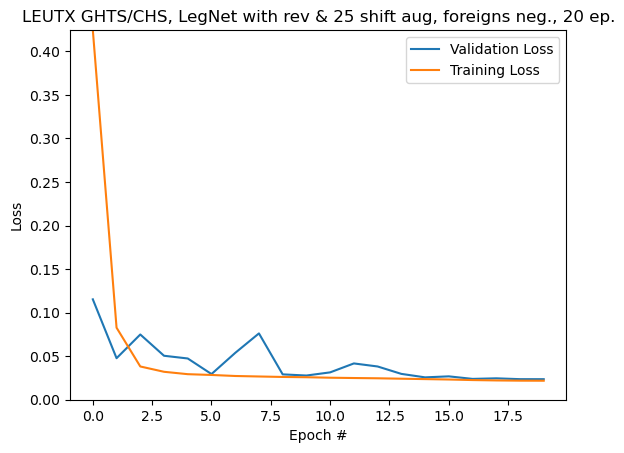

In [6]:
ax = plt.axes()
ax.set_ylim(0, max(metrics_df['val_loss'].max(), metrics_df['train_loss'].max()))
plt.plot(metrics_df['epoch'], metrics_df['val_loss'], label='Validation Loss')
plt.plot(metrics_df['epoch'], metrics_df['train_loss'], label='Training Loss')
plt.title('%s, %s' % (run_info, mod_info))
plt.ylabel('Loss')
plt.xlabel('Epoch #')
plt.legend(loc='upper right')
plt.show()


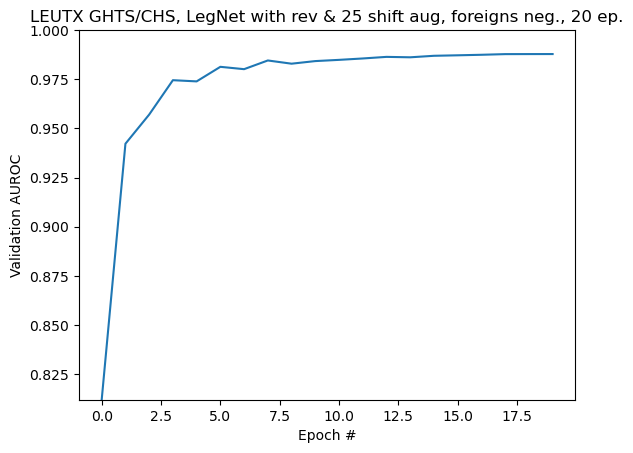

In [7]:
ax = plt.axes()
ax.set_ylim(metrics_df['val_auroc'].min(), 1)
plt.plot(metrics_df['epoch'], metrics_df['val_auroc'])
plt.title('%s, %s' % (run_info, mod_info))
plt.ylabel('Validation AUROC')
plt.xlabel('Epoch #')
plt.show()

In [8]:
preds_df = pd.read_csv(path_to_preds, sep='\t')
preds_df['avg_pred'] = (preds_df['forw_pred'] + preds_df['rev_pred']) / 2
preds = ('forw_pred', 'avg_pred', 'rev_pred')
preds_names = {'forw_pred': 'forward', 'rev_pred': 'reverse', 'avg_pred': 'averaged'}

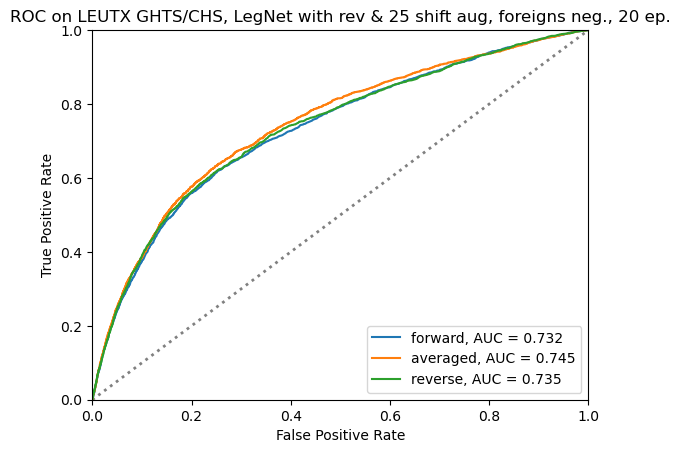

In [9]:
ax = plt.axes()
ax.axline([0, 0], [1, 1], linewidth=2, color='grey', linestyle=':')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
plt.title(f'ROC on {run_info}, {mod_info}')
    
for pred in preds:
    fpr, tpr, _ = metrics.roc_curve(preds_df['class_'], preds_df[pred])
    auc = metrics.roc_auc_score(preds_df['class_'], preds_df[pred])

    plt.plot(fpr, tpr, label=f'{preds_names[pred]}, AUC = {auc:.3}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
plt.show()

In [10]:
preds_df.head()

,chr,start,end,class_,forw_pred,rev_pred,avg_pred
0,chr10,869693,869994,1,0.000575,0.000544,0.000559
1,chr10,2882533,2882834,1,0.007490,0.000981,0.004235
2,chr10,3197372,3197673,1,0.000272,0.002306,0.001289
3,chr10,3785195,3785496,1,0.000301,0.000036,0.000168
4,chr10,4663324,4663625,1,0.004982,0.000106,0.002544


In [11]:
preds_df.tail()

,chr,start,end,class_,forw_pred,rev_pred,avg_pred
273299,chr8,145060180,145060481,0,0.000346,0.012530,0.006438
273300,chr8,145061098,145061399,0,0.000436,0.002714,0.001575
273301,chr8,145062905,145063206,0,0.000032,0.000031,0.000031
273302,chr8,145069645,145069946,0,0.000005,0.000022,0.000013
273303,chr8,145071975,145072276,0,0.000061,0.000137,0.000099
